In [1]:
# Import Packages
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, UpSampling2D, Activation
from keras import backend as K
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# Reshape and Rescale the images
x_train = x_train.reshape(-1,28,28,1) / 255
x_test = x_test.reshape(-1,28,28,1) / 255

In [4]:
x_test[0].shape

(28, 28, 1)

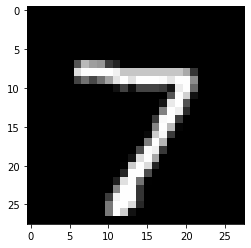

In [5]:
pylab.imshow(x_test[0].reshape(28, 28), cmap='gray')
pylab.show()

In [6]:
# Build the autoencoder
model = Sequential()
model.add(Conv2D(14, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(7, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(7, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(14, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(1, kernel_size=3, padding='same', activation='relu'))

model.compile(optimizer='adam', loss="mse")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 14)        140       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 14)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 7)         889       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 7)           0         
_________________________________________________________________
dropout_2 (Dropout)  

In [7]:
# Train the model
model.fit(x_train, x_train, epochs=3, batch_size=64, validation_data=(x_test, x_test), verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 21s 343us/step - loss: 0.0289 - val_loss: 0.0133
Epoch 2/3
60000/60000 [==============================] - 14s 238us/step - loss: 0.0201 - val_loss: 0.0108
Epoch 3/3
60000/60000 [==============================] - 14s 238us/step - loss: 0.0188 - val_loss: 0.0100


In [8]:
# Fitting testing dataset
restored_testing_dataset = model.predict(x_test)

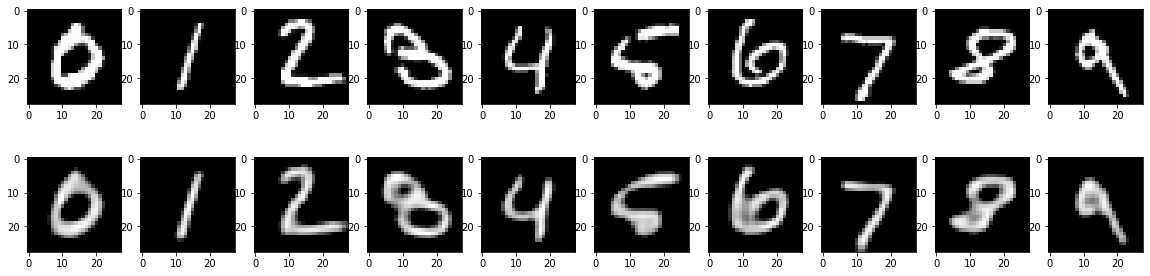

In [9]:
# Observe the reconstructed image quality
plt.figure(figsize=(20,5))
for i in range(10):
    index = y_test.tolist().index(i)
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test[index].reshape((28,28)), cmap='gray')
    plt.gray()
    plt.subplot(2, 10, i+11)
    plt.imshow(restored_testing_dataset[index].reshape((28,28)), cmap='gray')
    plt.gray()

In [10]:
# Extract the encoder
encoder = K.function([model.layers[0].input], [model.layers[4].output])

In [11]:
# Encode the training set
encoded_images = encoder([x_test])[0].reshape(-1,7*7*7)

In [12]:
encoded_images.shape

(10000, 343)

In [13]:
# Cluster the training set
kmeans = KMeans(n_clusters=10)
clustered_training_set = kmeans.fit_predict(encoded_images)

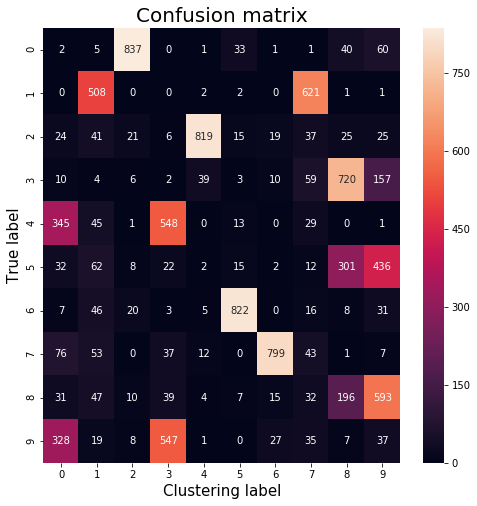

In [14]:
# Observe and compare clustering result with actual label using confusion matrix
cm = confusion_matrix(y_test, clustered_training_set)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Clustering label', fontsize=15)
plt.show()

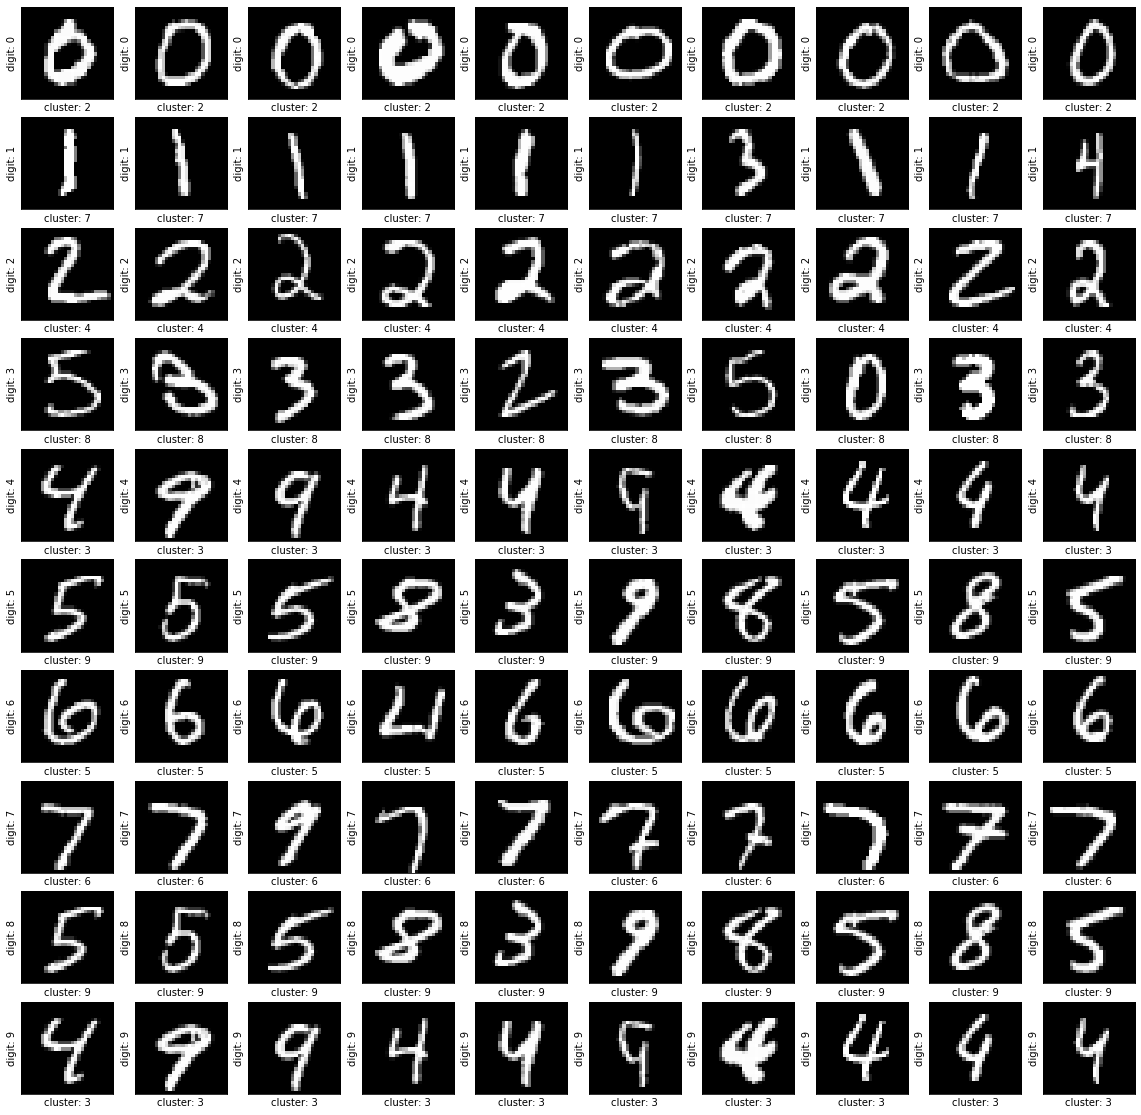

In [15]:
# Plot the actual pictures grouped by clustering
fig = plt.figure(figsize=(20,20))
for r in range(10):
    cluster = cm[r].argmax()
    for c, val in enumerate(x_test[clustered_training_set == cluster][0:10]):
        fig.add_subplot(10, 10, 10*r+c+1)
        plt.imshow(val.reshape((28,28)))
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.ylabel('digit: '+str(r))

In [16]:
from sklearn.metrics import accuracy_score, normalized_mutual_info_score

In [17]:
normalized_mutual_info_score(y_test, clustered_training_set)

c:\python368-64\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.5799339527200363